# Noisy QCNN mnist MNIST

In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/qdna/Downloads/QEmbedding-main/QEmbedding-main/')
import torch
from torch import nn
import pennylane as qml
import embedding
import data

dev = qml.device('default.qubit', wires=8)

ModuleNotFoundError: No module named 'embedding'

# NQE Optimization

In [11]:
feature_reduction = 'PCA8'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction, classes)

steps = 1000
learning_rate = 0.01
batch_size = 128
ansatz = 'SU4'


In [8]:
def data_reuploading_ansatz(params):
    for i in range(8):
        qml.RY(params[i], wires=i)
    for i in range(7):
        qml.IsingYY(params[i+8], wires=[i,i+1])
    qml.IsingYY(params[15], wires=[7,0])

def data_reuploading_embedding(num_layers,params,x):
    for l in range(num_layers):
        data_reuploading_ansatz(params[16 * l : 16 * (l + 1)])
        embedding.QuantumEmbedding1(x)

@qml.qnode(dev)
def data_reuploading_QCNN_classifier(num_layers, params, x):
    data_reuploading_embedding(num_layers, params, x)
    embedding.QCNN_eight(params[16 * num_layers: 16 * num_layers + 45], ansatz)
    return qml.expval(qml.PauliZ(4))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, num_layers):
    preds = [data_reuploading_QCNN_classifier(num_layers, weights, x) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

def circuit_training(X_train, Y_train, num_layers):
    num_weights = (num_layers * 16) + 45
    weights = np.random.random(num_weights, requires_grad=True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, num_layers), weights)

        loss_history.append(cost_new)
        if it % 200 == 0:
            print(f"iteration: {it}, cost: {cost_new}")
        
    return loss_history, weights

In [4]:
Losses_L1, Losses_L2, Losses_L3, Weights_L1, Weights_L2, Weights_L3 = [], [], [], [], [], []
for i in range(5):
    loss_L1, weight_L1 = circuit_training(X_train, Y_train, 1)
    loss_L2, weight_L2 = circuit_training(X_train, Y_train, 2)
    loss_L3, weight_L3 = circuit_training(X_train, Y_train, 3)


    Losses_L1.append(loss_L1)
    Losses_L2.append(loss_L2)
    Losses_L3.append(loss_L3)

    Weights_L1.append(weight_L1)
    Weights_L2.append(weight_L2)
    Weights_L3.append(weight_L3)
    

    
f = open('weights and losses.txt', 'a')
for i in range(5):
    f.write(f'Loss History L1 {i + 1}:')
    f.write('\n')
    f.write(str(Losses_L1[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L1{i + 1}:')
    f.write('\n')
    f.write(str(Weights_L1[i]))

for i in range(5):
    f.write(f'Loss History L2 {i + 1}:')
    f.write('\n')
    f.write(str(Losses_L2[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L2{i + 1}:')
    f.write('\n')
    f.write(str(Weights_L2[i]))

for i in range(5):
    f.write(f'Loss History L3 {i + 1}:')
    f.write('\n')
    f.write(str(Losses_L3[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L3{i + 1}:')
    f.write('\n')
    f.write(str(Weights_L3[i]))

f.close()

c:\Users\qdna\anaconda3\envs\QC\Lib\site-packages\autograd\numpy\numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration: 0, cost: 0.48943868167422777
iteration: 200, cost: 0.4510122923257869
iteration: 400, cost: 0.4167593942610002
iteration: 600, cost: 0.4345640646540798
iteration: 800, cost: 0.4213646152974793
iteration: 0, cost: 0.5097732922841438
iteration: 200, cost: 0.47518679961176646
iteration: 400, cost: 0.43160410087338513
iteration: 600, cost: 0.4108021093144709
iteration: 800, cost: 0.40272474424864574
iteration: 0, cost: 0.49578130438413115
iteration: 200, cost: 0.48816174900244774
iteration: 400, cost: 0.47552226140810405
iteration: 600, cost: 0.4705531042839662
iteration: 800, cost: 0.4492795355934584
iteration: 0, cost: 0.5141765421916478
iteration: 200, cost: 0.4859270454549235
iteration: 400, cost: 0.4742705906855844
iteration: 600, cost: 0.47273709446919254
iteration: 800, cost: 0.46576567597498425
iteration: 0, cost: 0.4991071612676784
iteration: 200, cost: 0.48851527349222473
iteration: 400, cost: 0.4785229306144603
iteration: 600, cost: 0.47131573874054916
iteration: 800,

# Part 4: Result 

Load the results

In [13]:
def data_read(PATH):
  textfile = open(PATH, 'r')
  data = np.array([])
  for line in textfile:
    a = np.array([float(v) for v in line.strip().split(" ")])
    data = np.append(data, a)
  return data

Loss_histories = data_read("Loss.txt").reshape(3, 5000)
Loss_histories_not_trained = Loss_histories[0].reshape(5,1000)
Loss_histories_Model2 = Loss_histories[1].reshape(5,1000)
Loss_histories_Model3 = Loss_histories[2].reshape(5,1000)


Weights = data_read("Weights.txt")
Weights_not_trained = Weights[0 : 5 * 61].reshape(5, 61)
Weights_Model2 = Weights[5 * 61 : 5 * 61 + 5 * 77].reshape(5, 77)
Weights_Model3 = Weights[5 * 61 + 5 * 77 : 5 * 61 + 5 * 77 + 5 * 93].reshape(5, 93)

LH0_mean, LH0_std = Loss_histories_not_trained.mean(axis=0), Loss_histories_not_trained.std(axis=0)
LH2_mean, LH2_std = Loss_histories_Model2.mean(axis=0), Loss_histories_Model2.std(axis=0)
LH3_mean, LH3_std = Loss_histories_Model3.mean(axis=0), Loss_histories_Model3.std(axis=0)

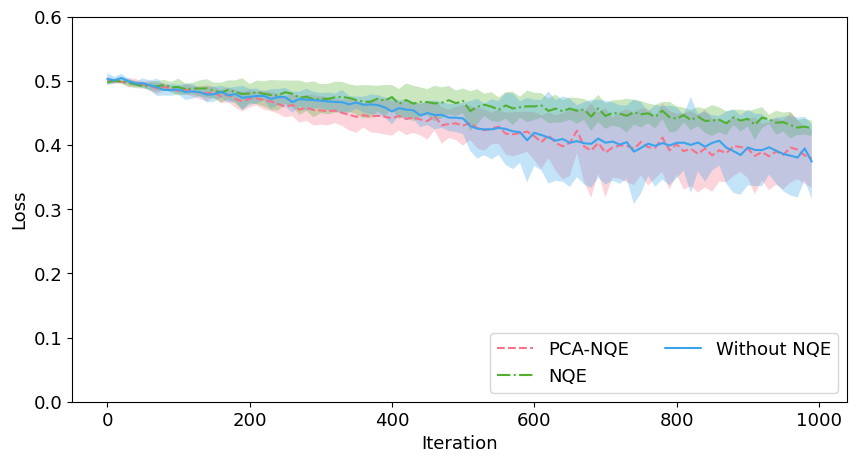

In [3]:
import seaborn as sns
n = 10
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 3)
with sns.axes_style("darkgrid"):    
    ax.plot(np.array(range(len(LH2_mean[::n]))) * n, LH2_mean[::n], label="L1", linestyle='dashed', c=clrs[0])
    ax.fill_between(np.array(range(len(LH2_mean[::n]))) * n, LH2_mean[::n]-LH2_std[::n], LH2_mean[::n]+LH2_std[::n], alpha=0.3,facecolor=clrs[0])

    ax.plot(np.array(range(len(LH3_mean[::n]))) * n, LH3_mean[::n], label="L2", linestyle='dashdot', c=clrs[1])
    ax.fill_between(np.array(range(len(LH3_mean[::n]))) * n, LH3_mean[::n]-LH3_std[::n], LH3_mean[::n]+LH3_std[::n], alpha=0.3,facecolor=clrs[1])

    ax.plot(np.array(range(len(LH0_mean[::n]))) * n, LH0_mean[::n], label="L3", linestyle='solid', c=clrs[2])
    ax.fill_between(np.array(range(len(LH0_mean[::n]))) * n, LH0_mean[::n]-LH0_std[::n], LH0_mean[::n]+LH0_std[::n], alpha=0.3,facecolor=clrs[2])




ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
#ax.set_title("mnist MNIST Noisy QCNN Loss History")
ax.legend(fontsize=13, ncol=2, loc=4)
ax.set_ylim((0.0,0.6))
plt.savefig("Loss History.pdf")

Calculate the classification accuracies for Model1,2

In [6]:
feature_reduction = 'PCA8'
classes=[0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

C:\Users\qdna\AppData\Local\Temp\ipykernel_21156\3504994494.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)


In [14]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_not_trained, accuracies_Model2_Fidelity, accuracies_Model3_Fidelity = [], [], []

for i in range(5):
    prediction_not_trained = [data_reuploading_QCNN_classifier(1, Weights_not_trained[i], x) for x in X_test]
    prediction_Model2_Fidelity = [data_reuploading_QCNN_classifier(2, Weights_Model2[i], x) for x in X_test]
    prediction_Model3_Fidelity = [data_reuploading_QCNN_classifier(3, Weights_Model3[i], x) for x in X_test]
    
    accuracy_not_trained = accuracy_test(prediction_not_trained, Y_test)
    accuracy_Model2_Fidelity = accuracy_test(prediction_Model2_Fidelity, Y_test)
    accuracy_Model3_Fidelity = accuracy_test(prediction_Model3_Fidelity, Y_test)

    accuracies_not_trained.append(accuracy_not_trained)
    accuracies_Model2_Fidelity.append(accuracy_Model2_Fidelity)
    accuracies_Model3_Fidelity.append(accuracy_Model3_Fidelity)

accuracies_not_trained = np.array(accuracies_not_trained)
accuracies_Model2_Fidelity = np.array(accuracies_Model2_Fidelity)
accuracies_Model3_Fidelity = np.array(accuracies_Model3_Fidelity)

In [15]:

print("Noisy QCNN classification accuracies:\n")
print("-------------------------------------\n")
print(f" Accuracy L1: {accuracies_not_trained.mean()} ± {accuracies_not_trained.std()}")
print(f" Accuracy L2: {accuracies_Model2_Fidelity.mean()} ± {accuracies_Model2_Fidelity.std()}")
print(f" Accuracy L3: {accuracies_Model3_Fidelity.mean()} ± {accuracies_Model3_Fidelity.std()}")

Noisy QCNN classification accuracies:

-------------------------------------

 Accuracy L1: 0.9704018912529552 ± 0.008919017397674932
 Accuracy L2: 0.9700236406619384 ± 0.010612945888679462
 Accuracy L3: 0.9252955082742318 ± 0.045734508737630054
